##  Sklearn PCG classification pipeline for the SIPAIM conference paper

In this notebook we tested two sets of features and some classifiers according to the SIPAIM paper.
The features came from a MP-LPC representation of a PCG signal, two sets were creating according to average the parameters or the samples of each PCG signal.

In [1]:
# Loading libraries
import os, sys 
import numpy as np
from os import listdir, path
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Functions used

In [2]:
# Function to count the elements in the series or list, give as output a frequency table
def to_frequency_table(data):
    frequencytable = {}
    for key in data:
        if key in frequencytable:
            frequencytable[key] += 1
        else:
            frequencytable[key] = 1
    return frequencytable
#  * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
# Function to split the data into train, test and validation datasets 
def MyTrainTestSplit (csv_data,PerTest):
    X , y = csv_data.iloc[:,:-1], csv_data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PerTest, random_state=1)
    return  X_train, y_train, X_test, y_test 
#  * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# Cross validation test and metrics calculation function
# The inputs are the Features "X_data" and classes "y_data", a random seed = "seed", 
# the number of Folds for the CV test "nFolds" and a list of objects which contains the bunch of classifiers "models"
#  * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
def AllCVTest(X_data,y_data,seed,nFolds,models):
    Acc = []
    Se = []
    Sp = []
    MCC = []
    nameClassifier = []
    for name, model in models:
        # If the model is SVM, parameters are being normalized 
        if  name =='SVM':
            X_scaled = preprocessing.scale(X_data)
            min_max_scaler = preprocessing.MinMaxScaler()
            X_data = min_max_scaler.fit_transform(X_scaled)
            le = preprocessing.LabelEncoder()
            le.fit(y_data)
            y_data = le.transform(y_data)
        # The stratified (due to data unbalancing) k-fold indexes to split the data. 
        kfold = model_selection.StratifiedKFold(n_splits=nFolds, random_state=seed, shuffle=True)
        # Accuracy scores coming out for each fold in the test (a list of k-fold values at each iteration)
        Scores = model_selection.cross_val_score(model,X_data,y_data, cv = kfold, scoring = 'accuracy')
        # Saving the scores for each model (classifier)
        Acc.append(Scores)
        # Predicted instances from the cross validation test caming from merging the output predictions at each fold
        predictedCV = model_selection.cross_val_predict(model, X_data, y_data ,cv=kfold)
        # Confusion matrix from the output predictions and actual classes 
        cm = confusion_matrix(y_data,predictedCV)
        # Specificity (Sp) calculation
        SpI = float(cm[1][1]) / float(cm[1][0]+cm[1][1])
        # Saving Sp at each iteration/classifier 
        Sp.append(SpI*100)
        # Sensitivity (Se) calculation 
        SeI = float(cm[0][0]) / float(cm[0][0]+cm[0][1])
        # Saving Se at each iteration/classifier
        Se.append(SeI*100)
        # Matthews correlation coefficient MCC
        MCCI = matthews_corrcoef(y_data,predictedCV)
        # Saving MCC at each iteration
        MCC.append(MCCI)
        # Saving the names of the models or classifiers to be ordered in a dataset
        nameClassifier.append(name)
    # Variables to return (output metrics)    
    return Acc, Se, Sp, MCC, nameClassifier

#  * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# Convert the list of accuracy scores to a data frame for the seaborn boxplotting (python)
#  * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
def Results2DataFrame (AccScores,nameClassifier,FeaturesLabel):
    # Reshape all the Accuracy Scores in a column
    ColRes = np.reshape(AccScores,(len(AccScores)*nFolds,1))
    # Saving the values 
    data = (ColRes)
    # Creating the dataFrame
    dFrame = pd.DataFrame()
    # Replicating the classifier names for each fold 
    namesClassifier = [nameClassifier for j in range(nFolds)]
    dFrame.loc[:,0] = np.reshape(namesClassifier,len(ColRes),1)
    # Replicating the name of the features set 
    dFrame.loc[:,1] = [FeaturesLabel]*len(ColRes)
    # Column containing all the data
    dFrame.loc[:,2] = data
    # Names of the columns 
    dFrame.columns = ['Model','Features','Value']
    return dFrame


## Reading the csv files from paths

In [3]:
allFeaturesPath = r'/Users/roilhi/Documents/AllCSVPCGFeatures/'
MP = path.join(allFeaturesPath,'MP_PCGFeatures_PerCycle.csv')
MP2 = path.join(allFeaturesPath,'MP_LPCFeatures2.csv')

## Creating the datasets from the files

In [4]:
dataset_A = pd.read_csv(MP)
dataset_B = pd.read_csv(MP2)
# Separating data from labels (target) values
XA, yA = dataset_A.iloc[:,:-1],dataset_A.iloc[:,-1]
XB, yB = dataset_B.iloc[:,:-1],dataset_B.iloc[:,-1]

## Performing the CV test

In [5]:
seed = 1 
nFolds = 10
scoring = 'accuracy'
# Defining a list of classifiers to be tested 
models = []
models.append(('LR', LogisticRegression(penalty='l2', dual=False, tol=0.0001,random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis(solver='svd')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(criterion='gini', splitter = 'best', random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(C=2.37, kernel='rbf',random_state=seed,class_weight='balanced')))
models.append(('RF',RandomForestClassifier(n_estimators = 100, min_samples_split = 2, n_jobs = -1, verbose = 1,random_state=seed)))

In [6]:
# Extracting the metrics from the data without resampling
AccA,SeA,SpA,MCCA,nameClassifier = AllCVTest(XA, yA, seed, nFolds,models)
AccB,SeB,SpB,MCCB,nameClassifier = AllCVTest(XB, yB ,seed, nFolds,models)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jo

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_job

## Creating dataframes from accuracy for seaborn plots

In [7]:
dfAcc_A = Results2DataFrame(AccA,nameClassifier,'Set A')
dfAcc_B = Results2DataFrame(AccB,nameClassifier,'Set B')

## Creating a dataframe to organize the remaining metric values

In [8]:
dfNoSmoteMetrics = pd.DataFrame({'Dataset':['SetA']*7+['SetB']*7 ,'Classifier':nameClassifier*2,
                          'Se':SeA+SeB,'Sp':SpA+SpB,'MCC':MCCA+MCCB})

In [9]:
dfNoSmoteMetrics

,Classifier,Dataset,MCC,Se,Sp
0,LR,SetA,0.321889,29.924812,94.453376
1,LDA,SetA,0.315283,29.473684,94.372990
2,KNN,SetA,0.347739,49.323308,85.771704
3,CART,SetA,0.381912,53.233083,85.811897
4,NB,SetA,0.177873,15.187970,95.659164
5,SVM,SetA,0.450456,76.090226,76.446945
6,RF,SetA,0.546957,51.278195,95.618971
7,LR,SetB,0.176271,11.127820,97.588424
8,LDA,SetB,0.167444,13.834586,95.980707
9,KNN,SetB,0.365076,35.789474,93.770096


## Performing test with oversampling

In [10]:
# Create the oversampling SMOTE object, calling the 'minority' option to oversample the minority class 
# to equalize the number of elements
sm = SMOTE(random_state = seed, ratio = 'minority')
# Oversampling the dataset A
xA_res, yA_res = sm.fit_sample(XA, yA)
# Oversampling the dataset B
xB_res, yB_res = sm.fit_sample(XB, yB)

In [11]:
seed = 1 
nFolds = 10
scoring = 'accuracy'
# Defining a list of classifiers to be tested 
models = []
models.append(('LR', LogisticRegression(penalty='l2', dual=False, tol=0.0001,random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis(solver='svd')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(criterion='gini', splitter = 'best', random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='rbf', C=1 ,random_state=seed)))
models.append(('RF',RandomForestClassifier(n_estimators = 100, min_samples_split = 2, n_jobs = -1, verbose = 1,random_state=seed)))

## Calculating the CV metrics from the resampled data

In [12]:
AccA_res,SeA_res,SpA_res,MCCA_res,nameClassifier = AllCVTest(xA_res, yA_res, seed, nFolds,models)
AccB_res,SeB_res,SpB_res,MCCB_res,nameClassifier = AllCVTest(xB_res, yB_res, seed, nFolds,models)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jo

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Paral

## Organizing the accuracy values for seaborn plot

In [13]:
dfResAcc_A = Results2DataFrame(AccA_res,nameClassifier,'Set A SMOTE')
dfResAcc_B = Results2DataFrame(AccB_res,nameClassifier,'Set B SMOTE')

## Organizing the remaining values in a dataframe

In [14]:
dfSmoteMetrics = pd.DataFrame({'Dataset':['SetA_SMOTE']*7+['SetB_SMOTE']*7 ,'Classifier':nameClassifier*2,
                          'Se':SeA_res+SeB_res,'Sp':SpA_res+SpB_res,'MCC':MCCA_res+MCCB_res})

In [15]:
dfSmoteMetrics 

,Classifier,Dataset,MCC,Se,Sp
0,LR,SetA_SMOTE,0.605991,83.239550,77.250804
1,LDA,SetA_SMOTE,0.590060,83.922830,74.839228
2,KNN,SetA_SMOTE,0.624790,98.231511,59.324759
3,CART,SetA_SMOTE,0.675252,85.490354,81.993569
4,NB,SetA_SMOTE,0.211809,14.750804,97.226688
5,SVM,SetA_SMOTE,0.558890,79.300643,76.567524
6,RF,SetA_SMOTE,0.836430,92.122186,91.519293
7,LR,SetB_SMOTE,0.377920,66.278135,71.463023
8,LDA,SetB_SMOTE,0.413996,71.020900,70.377814
9,KNN,SetB_SMOTE,0.732071,96.784566,74.598071


## Plotting the accuracy scores

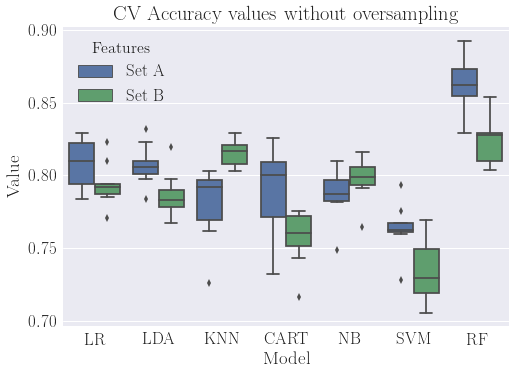

In [16]:
# Setting the font size and LaTeX type for the boxplot
sns.set(font_scale=1.7)
NoSMOTE  = [dfAcc_A,dfAcc_B]
NoSMOTEAcc = pd.concat(NoSMOTE)
plt.rc('text', usetex=True)
plt.rc('font',family='serif')
plt.rc('font',**{'family':'serif','serif':['Arial']})
fig, ax = plt.subplots()
b = sns.boxplot(data = NoSMOTEAcc,
                hue = 'Features', # different colors for different 'cls'
                x = 'Model',
                y = 'Value',
                order = ['LR', 
                         'LDA',
                         'KNN',
                         'CART',
                         'NB',
                         'SVM',
                          'RF'])
handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)
sns.plt.title('CV Accuracy values without oversampling') # You can change the title here
plt.show()

In [17]:
# Save the first plot into a pdf file
fig.set_size_inches(11, 9)
ax.get_figure().savefig('/Users/roilhi/Desktop/AccScoresCV_NoSMOTE.pdf', dpi=180) 
plt.close(fig)

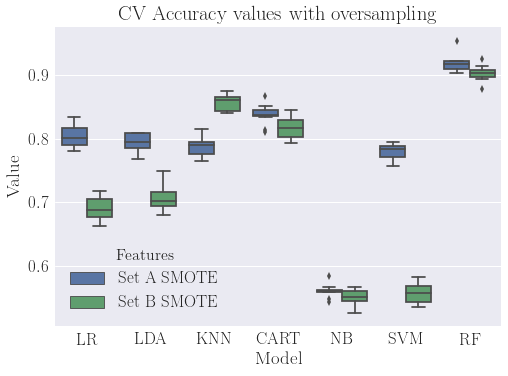

In [18]:
SMOTEData  = [dfResAcc_A, dfResAcc_B]
SMOTEAcc = pd.concat(SMOTEData)
fig, ax = plt.subplots()
b = sns.boxplot(data = SMOTEAcc,
                hue = 'Features', # different colors for different 'cls'
                x = 'Model',
                y = 'Value',
                order = ['LR', 
                         'LDA',
                         'KNN',
                         'CART',
                         'NB',
                         'SVM',
                          'RF'])
handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)
sns.plt.title('CV Accuracy values with oversampling') # You can change the title here
plt.show()

In [19]:
# Save the second plot into a pdf file
fig.set_size_inches(11, 9)
ax.get_figure().savefig('/Users/roilhi/Desktop/AccScoresCV_SMOTE.pdf', dpi=180) 